In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

# For some reason, we can't learn the course of cadherin????

In [86]:
def load_data():
    loaddir = '../Public/WT/ECad-GFP/ensemble/'
    cad = np.load(os.path.join(loaddir, 'raw2D.npy'), mmap_mode='r')

    loaddir = '../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
    sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')
    vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')
    t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
    y = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
    x = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')

    t_min = -10
    t_max = 25
    mask = np.logical_and(t >= t_min, t <= t_max)
    t = t[mask]
    sqh = sqh[mask].transpose(0, 3, 4, 1, 2)

    cad = gaussian_filter(cad[mask], sigma=(0, 8, 8))
    cad = 0.5 * (cad + cad[:, ::-1, :])
    vel = vel[mask].transpose(0, 2, 3, 1)

    print('Data shapes')
    print(f'Sqh: {sqh.shape}')
    print(f'Cad: {cad.shape}')
    print(f'Vel: {vel.shape}')

    nAP = x.shape[1]
    nDV = y.shape[0]
    nTP = t.shape[0]

    XX = np.broadcast_to(x[None], (nTP, nDV, nAP))
    YY = np.broadcast_to(y[None], (nTP, nDV, nAP))
    TT = np.broadcast_to(t[:, None, None], (nTP, nDV, nAP))

    print('Coordinates shapes')
    print(f'XX: {XX.shape} Range [{XX.min():g}, {XX.max():g}] um')
    print(f'YY: {YY.shape} Range [{YY.min():g}, {YY.max():g}] um')
    print(f'TT: {TT.shape} Range [{TT.min():g}, {TT.max():g}] um')

    lower_bound = np.array([TT.min(), YY.min(), XX.min()])
    upper_bound = np.array([TT.max(), YY.max(), XX.max()])

    t = TT.flatten()[:, None]
    y = YY.flatten()[:, None]
    x = XX.flatten()[:, None]
        
    print('Training data')
    sqh_train = sqh.reshape([-1, *sqh.shape[3:]])
    cad_train = cad.reshape([-1, 1])
    vel_train = vel.reshape([-1, *vel.shape[3:]])

    print(t.shape, y.shape, x.shape)
    print(sqh_train.shape, cad_train.shape, vel_train.shape)

    x_train = x
    y_train = y
    t_train = t


    return {
        'sqh_train': sqh_train,
        'cad_train': cad_train,
        'vel_train': vel_train,
        'x_train': x_train,
        'y_train': y_train,
        't_train': t_train,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

In [87]:
data = load_data()
data.pop('sqh_train')
data.pop('vel_train')

class CadherinOnlyPINN(nn.Module):
    def __init__(self,
                 t_train, y_train, x_train,
                 cad_train,
                 lower_bound, upper_bound, 
                 n_hidden_layers=7, hidden_width=256,
                 beta=1e0, lr=1e-4):
        super().__init__()

        self.init_model(n_hidden_layers, hidden_width)
        self.init_data(t_train, y_train, x_train, 
                       cad_train,
                       lower_bound, upper_bound)	

        self.optimizer_Adam = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.beta = beta
        
        self.model.apply(self.init_weights) 

    def init_model(self, n_hidden_layers=7, hidden_width=64, n_outs=7):
        self.n_hidden_layers = n_hidden_layers
        self.hidden_width = hidden_width
        act = Sin
        layers = [3,] + ([hidden_width,] * n_hidden_layers) + [n_outs,]
        lst = []
        for i in range(len(layers)-2):
            lst.append(nn.Linear(layers[i], layers[i+1]))
            lst.append(act())
        lst.append(nn.Linear(layers[-2], layers[-1]))
        self.model = nn.Sequential(*lst)

        self.sqh_coefs = to_param(torch.zeros(8), requires_grad=True)
        self.model.register_parameter('sqh_coefs', self.sqh_coefs)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.0)

    def init_data(self, 
                  t_train, y_train, x_train, 
                  cad_train,
                  lower_bound, upper_bound):
        self.t_train = to_param(t_train, requires_grad=True)
        self.y_train = to_param(y_train, requires_grad=True)  
        self.x_train = to_param(x_train, requires_grad=True)

        self.cad_train = to_param(cad_train, requires_grad=False)

        self.lb = to_param(lower_bound, requires_grad=False)
        self.ub = to_param(upper_bound, requires_grad=False)

    def forward(self, t, y, x):
        '''
        The basic version predicts a 7-component vector:
            Myosin, Cadherin, Flow
        '''
        X = torch.cat([t, y, x], dim=-1)
        H = 2. * (X - self.lb) / (self.ub - self.lb) - 1.0
        scv = self.model(H)
        sqh = scv[:, 0:4].reshape([scv.shape[0], 2, 2])
        cad = scv[:, 4:5].squeeze() #Cadherin is positive
        vel = scv[:, 5:7]
        return sqh, cad, vel

    def mse_loss(self, N=500):
        idx = np.random.choice(self.t_train.shape[0], N, replace=False)
        t, y, x = self.t_train[idx], self.y_train[idx], self.x_train[idx]
        sqh, cad, vel = self(t, y, x)

        #MSE loss
        cad_loss = (cad - self.cad_train[idx]).pow(2).sum() / N

        return cad_loss + self.phys_loss(t, y, x)

    def gradient(self, x, *y):
        '''
        Take the gradient of a field x with respect to variables y
        Populates a tensor of size [*x.shape, len(y)] such that
        gradient[..., i] is the gradient of x with respect to y[i]

        x is assumed to have shape [N, C] or is reshaped to have that
        '''
        x0 = x.view([x.shape[0], -1])
        dxdy = []
        for yi in y:
            dxdyi = torch.stack([
                autograd.grad(x0[..., i], y, grad_outputs=torch.ones_like(x0[..., i]),
                              retain_graph=True, create_graph=True)[0] 
                for i in range(x0.shape[-1])], dim=-1)
            dxdyi = dxdyi.reshape(x.shape)
            dxdy.append(dxdyi)
        return torch.stack(dxdy, dim=-1).squeeze()
    
    def phys_loss(self, t=None, y=None, x=None, N=5000):
        sqh, cad, vel = self(t, y, x)

        #Conservation law for cadherin
        dt_cad = self.gradient(cad, t)
        grad_c = self.gradient(cad, y, x)
        cad_dyn = dt_cad + torch.einsum('bi,bi->b', vel, grad_c)

        phys = cad_dyn.pow(2).sum()
        return phys / t.shape[0]

    def loss_func(self):
        self.optimizer.zero_grad()
        loss = self.mse_loss()
        loss.backward()

        if self.iter % self.save_every == 0:
            print(f'Iteration {self.iter:d}\tLoss: {loss.item():e}')
            torch.save(self.state_dict(), self.save_name)

        self.iter += 1

        return loss

    def train(self, num_iter, save_every=100):
        self.iter = 0
        self.save_every = save_every
        self.save_name = f'{self.__class__.__name__}_beta={self.beta:.0e}.ckpt'

        self.optimizer = self.optimizer_Adam
        self.iter = 0

        for step in range(num_iter):
            loss = self.loss_func()
            self.optimizer.step()
        
model = CadherinOnlyPINN(**data)
model.to(torch.device('cuda:0'))
model.train(1000)

Data shapes
Sqh: (36, 236, 200, 2, 2)
Cad: (36, 236, 200)
Vel: (36, 236, 200, 2)
Coordinates shapes
XX: (36, 236, 200) Range [3.22966, 455.701] um
YY: (36, 236, 200) Range [3.22657, 536.891] um
TT: (36, 236, 200) Range [-10, 25] um
Training data
(1699200, 1) (1699200, 1) (1699200, 1)
(1699200, 2, 2) (1699200, 1) (1699200, 2)
Iteration 0	Loss: 6.086039e+02
Iteration 100	Loss: 1.079839e+01
Iteration 200	Loss: 1.355718e+01
Iteration 300	Loss: 1.609436e+01
Iteration 400	Loss: 1.246959e+01
Iteration 500	Loss: 1.075054e+01
Iteration 600	Loss: 1.343192e+01
Iteration 700	Loss: 1.491448e+01
Iteration 800	Loss: 1.441428e+01
Iteration 900	Loss: 1.399012e+01


torch.Size([1699200, 1])


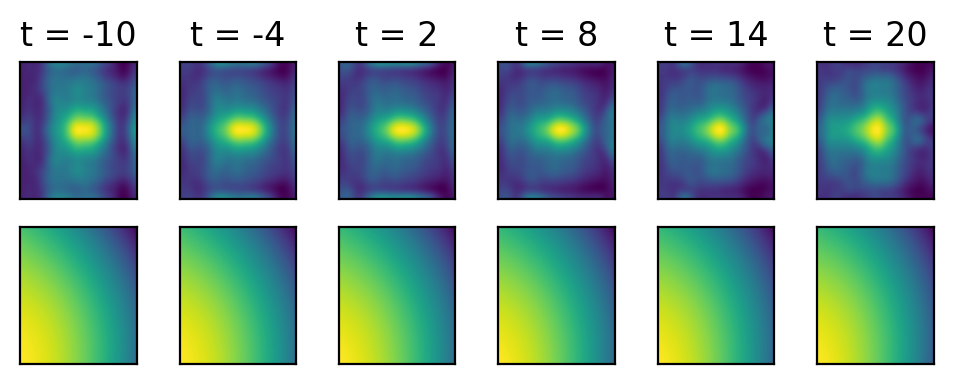

In [88]:
from utils.plot_utils import *
import torch

nTP, nDV, nAP = 36, 236, 200

with torch.no_grad():
    m1, c1, v1 = model(model.t_train, model.y_train, model.x_train)
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2])
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2])
    c1 = c1.cpu().numpy().reshape([nTP, nDV, nAP])
    print(model.cad_train.shape)
    c0 = model.cad_train.cpu().numpy().reshape([nTP, nDV, nAP])
    
    m1 = m1.transpose(0, 3, 4, 1, 2)
    v1 = v1.transpose(0, 3, 1, 2)
    times = model.t_train.cpu().numpy().reshape([nTP, nDV, nAP])[..., 0, 0]
        
N = 6
fig, ax = plt.subplots(2, N, dpi=200, figsize=(N,2))
dt = min(10, m1.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    color_2D(ax[0, i], c0[i*dt], cmap='viridis')
    color_2D(ax[1, i], c1[i*dt], cmap='viridis')
    
    for j in range(2):
        ax[j, i].set_ylim([dv_min, dv_max])